In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import pandas_profiling
import sys,os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas.api.types as ptypes
from numpy.random import choice
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from random import randrange

import warnings
warnings.filterwarnings('ignore')



## Can we leverage well-known feature selection strategies, such as Chi-squared ranking, toselect features that are more data-error robust?

Let's collect some statistics about every feature before corrupting the data. 


**Chi square** is a non-parametric test that is used to show association between two qualitative variables (like gender and eye color), while **correlation** (Pearson coefficient) is used to test the correlation between two quantitative variables (like heart rate and blood pressure)

In the given dataset we have only quantitative data 

In [2]:
df=pd.read_csv('./amit/data.csv')
print(df.columns)
df.head()
df.shape

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


(569, 32)

In [3]:
def load_data():
    df=pd.read_csv('./amit/data.csv')
    df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
    y = df['diagnosis']
    X = df.drop(['diagnosis','id'],axis=1)
    return X,y
X,y =load_data()
feature_cols = X.columns.to_list()

In [4]:
feature_stats = X.describe().T[['mean','std','max','min']]
df.corr()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,1.000000,0.074626,0.099770,0.073159,0.096893,-0.012968,0.000096,0.050080,0.044158,-0.022114,...,0.082405,0.064720,0.079986,0.107187,0.010338,-0.002968,0.023203,0.035174,-0.044224,-0.029866
radius_mean,0.074626,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.099770,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.073159,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.096893,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,-0.012968,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.000096,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.050080,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.044158,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,-0.022114,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


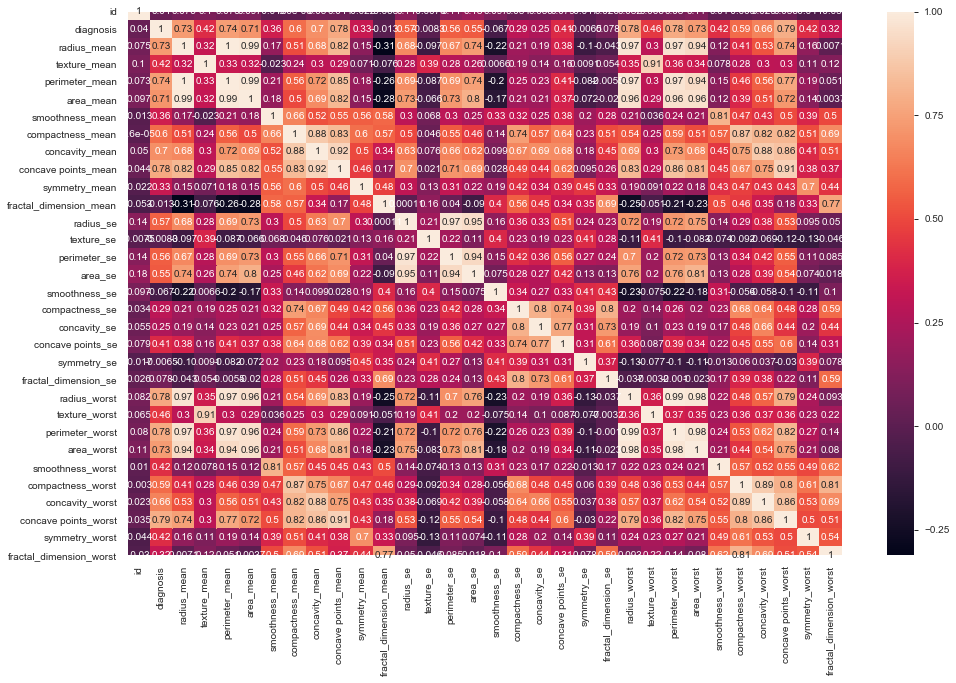

In [5]:
df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
corr_matrix = df.corr()
# plot the correlation heatmap
plt.figure(figsize=(16,10))

sns.heatmap(corr_matrix,annot=True,
        xticklabels=df.columns,
        yticklabels=df.columns)



#Correlation with output variable
cor_target = abs(corr_matrix["diagnosis"])

mean_correlation = abs(X.corr()).describe().T['mean']

corr_ranking = pd.DataFrame([cor_target,mean_correlation]).T.rename(columns={"diagnosis": "target_correlation", "mean": "mean_correlation"})
corr_ranking.drop(['id','diagnosis'],axis=0,inplace=True)

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
ranking_names =map(lambda x: feature_cols[x],fit.ranking_)
print("Feature Ranking: %s" % list(ranking_names))

Num Features: 3
Selected Features: [False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False  True  True False False]
Feature Ranking: ['compactness_mean', 'texture_se', 'perimeter_worst', 'concavity_worst', 'texture_worst', 'symmetry_mean', 'area_mean', 'concave points_mean', 'compactness_se', 'compactness_worst', 'texture_mean', 'fractal_dimension_mean', 'concavity_mean', 'smoothness_se', 'symmetry_worst', 'perimeter_se', 'area_se', 'area_worst', 'smoothness_worst', 'concave points_worst', 'symmetry_se', 'radius_se', 'concave points_se', 'radius_worst', 'fractal_dimension_se', 'perimeter_mean', 'texture_mean', 'texture_mean', 'smoothness_mean', 'concavity_se']


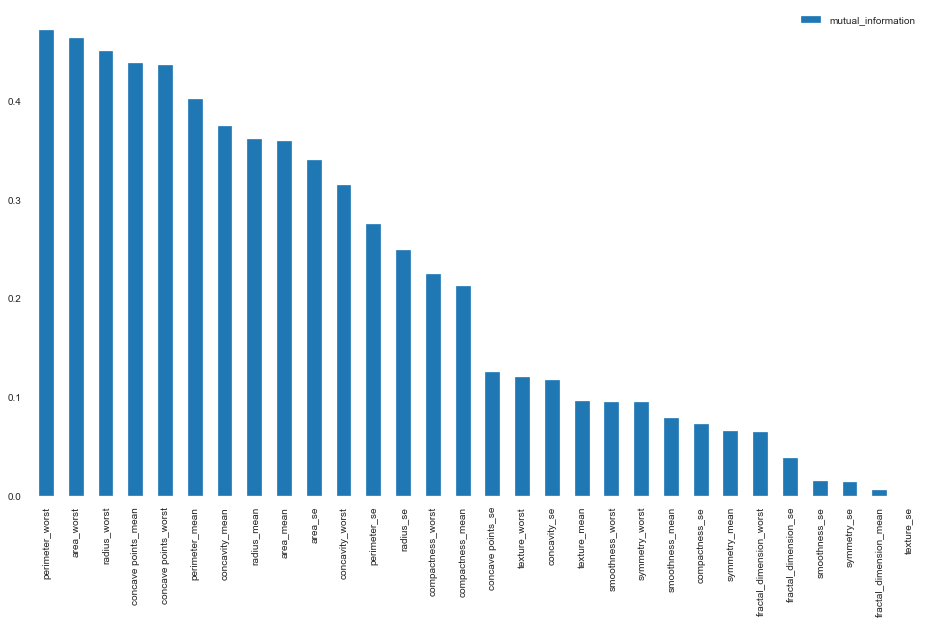

In [7]:
mutual_info = np.array(mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=42))

mutual_info= pd.DataFrame(mutual_info,columns=["mutual_information"],index=feature_cols)

mutual_info.sort_values(by='mutual_information',ascending=False)\
        .plot(kind='bar',figsize=(16,9))

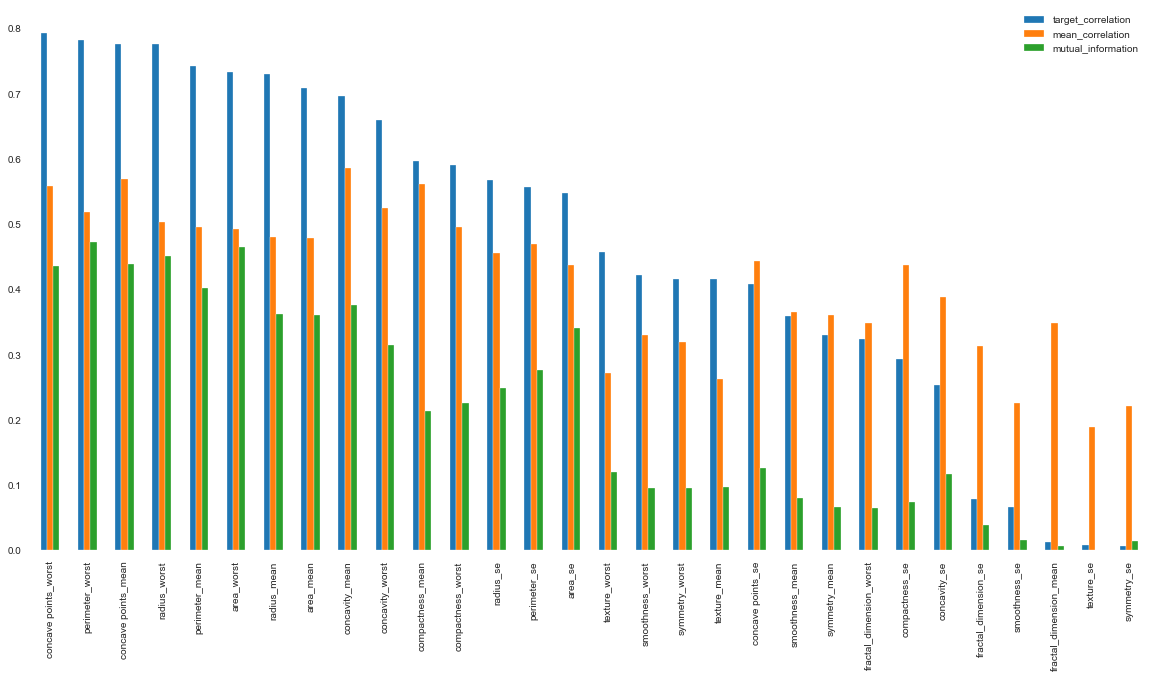

In [8]:
pd.concat([corr_ranking , mutual_info],axis=1).sort_values(by=['target_correlation','mean_correlation','mutual_information'],ascending=False).plot(kind='bar',figsize=(20,10))

In [9]:
from DataCorruption.DataCorruptor import NumericDataCorruptor
    
data_corruptor = NumericDataCorruptor(X,feature_stats,feature_cols)
data_corruptor.get_dataset_with_corrupted_col('radius_mean')

      A     B    C
0  30.0  20.0  0.1
1  10.0   NaN  0.5
2  15.0  30.0  0.2
      A     B    C
0  30.0  20.0  0.1
1  10.0   NaN  NaN
2  15.0  30.0  0.2
      A     B    C
0  30.0  20.0  0.1
1  10.0   NaN  NaN
2  15.0   NaN  0.2
   A  B  C
0  0  0  0
1  0  1  1
2  0  1  0
Corrutping 0.95 percent of : radius_mean


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,15.020199,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,30.927134,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.690000,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,4.859868,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,27.232110,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.248670,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,28.250000,20.13,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,28.080000,16.60,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,13.065522,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [10]:
#implement featureimportances attributes in random forest  to see the importance of a feature 
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X,y)
importances = clr_rf_5.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" The RandomForest Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s  (%f)" % (indices[f],feature_cols[indices[f]], importances[indices[f]]))

 The RandomForest Feature ranking:
27. concave points_worst  (0.140335)
20. radius_worst  (0.129760)
22. perimeter_worst  (0.125126)
23. area_worst  (0.088241)
6. concavity_mean  (0.077929)
0. radius_mean  (0.074809)
7. concave points_mean  (0.063891)
2. perimeter_mean  (0.049381)
3. area_mean  (0.047821)
26. concavity_worst  (0.029014)
25. compactness_worst  (0.017581)
1. texture_mean  (0.016742)
21. texture_worst  (0.016370)
13. area_se  (0.015968)
24. smoothness_worst  (0.015280)
12. perimeter_se  (0.010743)
10. radius_se  (0.009878)
28. symmetry_worst  (0.008140)
16. concavity_se  (0.007374)
17. concave points_se  (0.007320)
29. fractal_dimension_worst  (0.007030)
5. compactness_mean  (0.006503)
19. fractal_dimension_se  (0.005278)
15. compactness_se  (0.005184)
11. texture_se  (0.004649)
4. smoothness_mean  (0.004626)
8. symmetry_mean  (0.004142)
14. smoothness_se  (0.003947)
18. symmetry_se  (0.003615)
9. fractal_dimension_mean  (0.003324)


In [11]:
# This function returns you a pippeline with a fitted model for specified features repesentation 
def get_pipeline(X):
# We create the preprocessing pipelines for both numeric and categorical data.
    numeric_features = X.select_dtypes(include="number").columns.to_list()#['age', 'fare']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_features = X.select_dtypes(include="object").columns.to_list()
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
    return clf 

top_5_rfe =['area_mean', 'concavity_mean', 'area_se', 'concavity_worst',
       'symmetry_worst']

top_10_rfe = ['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'fractal_dimension_mean', 'area_se', 'concavity_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst']

top_5_error_ranking= ['texture_mean','radius_mean','perimeter_mean','area_mean','fractal_dimension_mean']
top_10_error_ranking= ['texture_mean','radius_mean','perimeter_mean','area_mean','fractal_dimension_mean',
                       'compactness_mean','smoothness_mean','concave points_mean','concavity_mean','symmetry_mean']

clf = get_pipeline(X)
clf_rfe = get_pipeline(X[top_5_rfe])
clf_rfe_top10 = get_pipeline(X[top_5_rfe])
clf_rfe_top5_error = get_pipeline(X[top_5_error_ranking])
clf_rfe_top10_error = get_pipeline(X[top_10_error_ranking])

In [12]:
X,y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


X_test_rfe, X_train_rfe =X_test[top_5_rfe],X_train[top_5_rfe]
X_test_5_error, X_train_5_error =X_test[top_5_error_ranking],X_train[top_5_error_ranking]
X_test_10_error, X_train_10_error =X_test[top_10_error_ranking],X_train[top_10_error_ranking]


In [13]:
clf_rfe_top10_error.fit(X_train_10_error, y_train)

clf_rfe_top5_error.fit(X_train_5_error, y_train)
clf_rfe.fit(X_train_rfe, y_train)
clf.fit(X_train, y_train)


clean_test_baseline= clf.score(X_test, y_test)
print("All featues model score: %.3f" % clean_test_baseline)

clean_test_baseline= clf_rfe.score(X_test_rfe, y_test)
print("RFE selected features  model score: %.3f" % clean_test_baseline)

clean_test_baseline= clf_rfe_top5_error.score(X_test_5_error, y_test)
print("Top 5 Error exepriemnt featues model score: %.3f" % clean_test_baseline)

clean_test_baseline= clf_rfe_top10_error.score(X_test_10_error, y_test)
print("TOp 10 Error exepriemnt featues model score: %.3f" % clean_test_baseline)

All featues model score: 0.991
RFE selected features  model score: 0.974
Top 5 Error exepriemnt featues model score: 0.930
TOp 10 Error exepriemnt featues model score: 0.947


In [14]:
data_corruptor = NumericDataCorruptor(X_test,feature_stats,feature_cols)
res_= []

print('Feature Ranking Error')
for idx,column in enumerate(feature_cols):
    corrupted_score = clf.score(data_corruptor.get_dataset_with_corrupted_col(column), y_test)
    loss = corrupted_score - clean_test_baseline
    res_.append([column,corrupted_score,loss])
    print("model score: %.3f" % corrupted_score)

Feature Ranking Error
Corrutping 0.95 percent of : radius_mean
model score: 0.991
Corrutping 0.95 percent of : texture_mean
model score: 0.982
Corrutping 0.95 percent of : perimeter_mean
model score: 0.947
Corrutping 0.95 percent of : area_mean
model score: 0.860
Corrutping 0.95 percent of : smoothness_mean
model score: 0.807
Corrutping 0.95 percent of : compactness_mean
model score: 0.833
Corrutping 0.95 percent of : concavity_mean
model score: 0.798
Corrutping 0.95 percent of : concave points_mean
model score: 0.772
Corrutping 0.95 percent of : symmetry_mean
model score: 0.737
Corrutping 0.95 percent of : fractal_dimension_mean
model score: 0.737
Corrutping 0.95 percent of : radius_se
model score: 0.737
Corrutping 0.95 percent of : texture_se
model score: 0.719
Corrutping 0.95 percent of : perimeter_se
model score: 0.658
Corrutping 0.95 percent of : area_se
model score: 0.623
Corrutping 0.95 percent of : smoothness_se
model score: 0.596
Corrutping 0.95 percent of : compactness_se
mod

In [16]:
#pd.DataFrame(res_,columns=['col_name','model_score','loss']).sort_values(by='loss',ascending=False)
#disrupted_feature_ranking = pd.concat([pd.DataFrame(res,columns=['feature','score','loss']),] ).sort_values(by='loss',ascending=False).drop('score',axis=1)

In [17]:
def do_experiment(clf,X_test,y_test,feature_cols):
    
    data_corruptor = NumericDataCorruptor(X_test,feature_stats,feature_cols)
    total_cells = X_test.shape[0] * X_test.shape[1]
    res= []
    for n in range(total_cells):
            corrupted_score = clf.score(data_corruptor.get_dataset_with_corrupted_cell(), y_test)
            res.append([(n/total_cells),corrupted_score])
    df = pd.DataFrame(res,columns=['%Corrupted','Score'])
    
    print('Area under the curve {}'.format(np.trapz(df['Score'],df['%Corrupted'])))
    return df


In [22]:
experiment_df = do_experiment(clf,X_test,y_test,feature_cols)
expeirment_df_rfe = do_experiment(clf_rfe,X_test_rfe,y_test,top_5_rfe)
experiment_df_5_error = do_experiment(clf_rfe_top5_error,X_test_5_error,y_test,top_5_error_ranking)
experiment_df_10_error = do_experiment(clf_rfe_top10_error,X_test_10_error,y_test,top_10_error_ranking)

Area under the curve 0.6309428542115523
Area under the curve 0.7176746691289627
Area under the curve 0.6277162203755002
Area under the curve 0.6944521391197291


In [ ]:
Area under the curve 0.5633669334154099
Area under the curve 0.7068867343798092
Area under the curve 0.6390889504462911
Area under the curve 0.7165897199138196

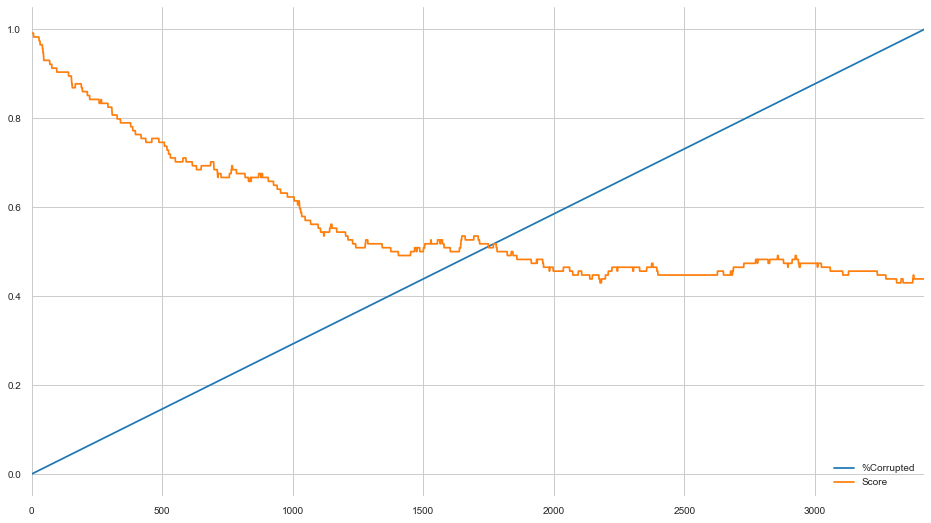

In [19]:
experiment_df.plot(figsize=(16,9),grid=True)


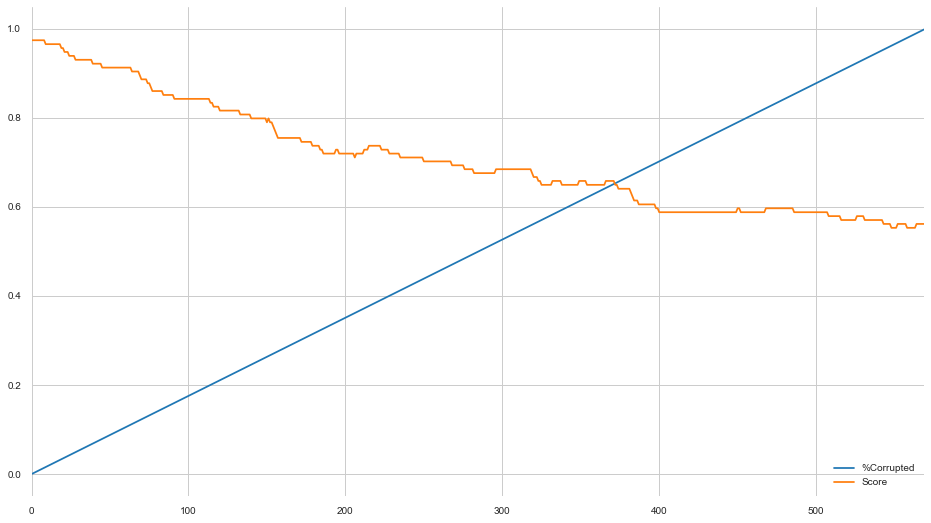

In [20]:
expeirment_df_rfe.plot(figsize=(16,9),grid=True)


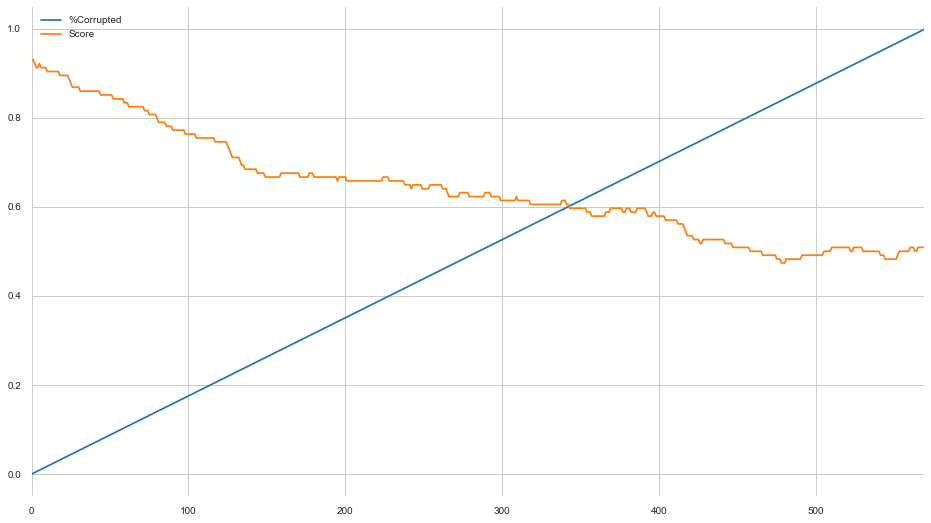

In [21]:
experiment_df_5_error.plot(figsize=(16,9),grid=True)